## Import Dependencies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import tools
import plotly.io as pio
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import plot, iplot, download_plotlyjs, init_notebook_mode

import gc
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

In [2]:
%matplotlib inline
py.init_notebook_mode(connected=True)

## Data Preparation

### Load Data

In [3]:
data = pd.read_csv('../datasets/creditcard.csv')
data.shape

(284807, 31)

### Data Exploration

In [4]:
data.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [5]:
print(data.isnull().mean()*100)

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64


In [6]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Data Visualization

#### Time-based Transaction Density

In [7]:
class_legit = data.loc[data['Class'] == 0]["Time"]
class_fraud = data.loc[data['Class'] == 1]["Time"]

fig = ff.create_distplot([class_legit, class_fraud], ['Legit Transactions', 'Fraud Transactions'], colors=['#519872', '#041b15'], show_hist=False, show_rug=False)
fig['layout'].update(title='Time-based Transaction Density', xaxis=dict(title='Time'), width=900, height=500)
fig.write_image('../results/visualizations/time_transaction_density.png', scale=2)
pio.show(fig)

#### Data Imbalance

In [8]:
class_val = data['Class'].value_counts()
df = pd.DataFrame({'Class': class_val.index, 'Values': class_val.values})

graph_data = go.Bar(
    x = df['Class'],
    y = df['Values'],
    name = 'Credit Card Data Imbalance',
    marker = dict(color='#519872'),
    text = df['Values']
)

layout = dict(
    title = 'Credit Card Data Imbalance',
    xaxis = dict(title='Class', showticklabels=True),
    yaxis = dict(title='Total Transactions'),
    hovermode = 'closest',
    width = 500
)

fig = go.Figure(data=[graph_data], layout=layout)
fig.write_image('../results/visualizations/credit_card_imbalance.png', scale=2)
pio.show(fig)

#### Transactions Amount

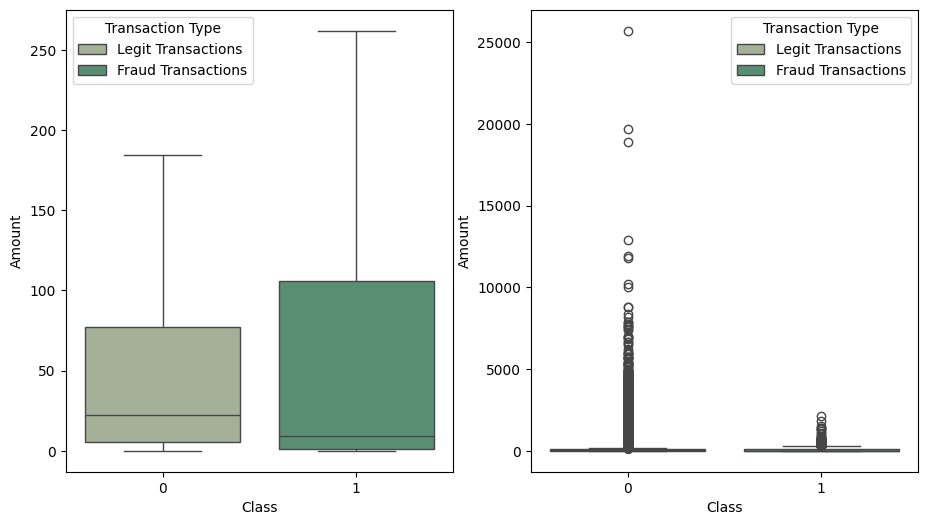

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(11,6))

sns.boxplot(ax=ax[0], x='Class', y='Amount', hue='Class', data=data, palette=['#a4b494', '#519872'], showfliers=False)
sns.boxplot(ax=ax[1], x='Class', y='Amount', hue='Class', data=data, palette=['#a4b494', '#519872'], showfliers=True)

for a in ax:
    handles, _ = a.get_legend_handles_labels()
    a.legend(handles, ['Legit Transactions', 'Fraud Transactions'], title="Transaction Type")

plt.savefig('../results/visualizations/transactions_amount.png', dpi=166.67)
plt.show()

#### Feature Correlation

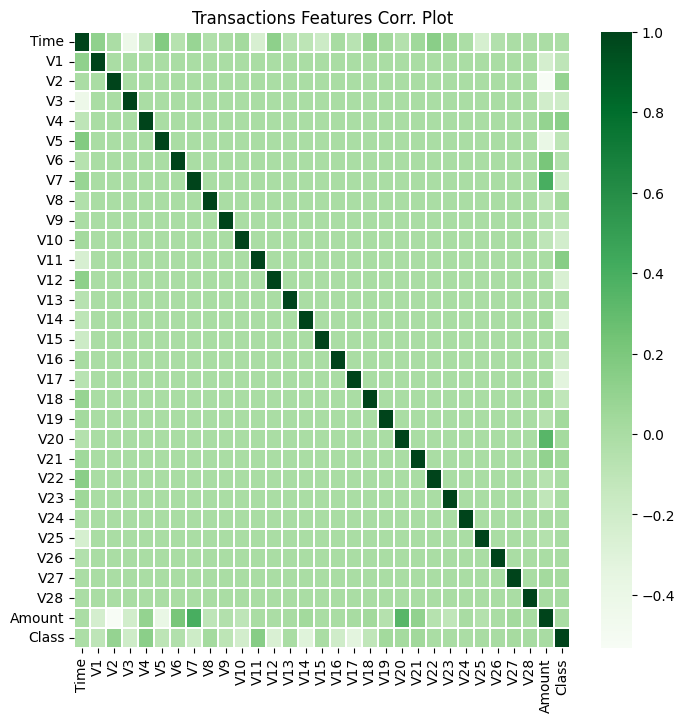

In [10]:
data_corr = data.corr()

plt.figure(figsize=(8,8))
sns.heatmap(data_corr, xticklabels=data_corr.columns, yticklabels=data_corr.columns, cmap='Greens', linewidths=0.1)
plt.title('Transactions Features Corr. Plot')
plt.savefig('../results/visualizations/feature_correlation.png', dpi=125)
plt.show()

## Model Training

### Split data into features (X) and target (y)

In [11]:
X = data.drop(['Class'], axis=1)
y = data['Class']

### Train-Test-Val Split

Training set - 80%,
Test set - 10%,
Validation set - 10%

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

### Define Model

#### RandomForestClassifier

In [13]:
rfc = RandomForestClassifier(n_jobs=4, random_state=42, criterion='gini', n_estimators=100, verbose=False)
rfc.fit(X_train, y_train.values)

RandomForestClassifier(n_jobs=4, random_state=42, verbose=False)

In [14]:
rfc_pred = rfc.predict(X_val)

### AdaBoostClassifier

In [15]:
abc = AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=42)
abc.fit(X_train, y_train.values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=42)

In [16]:
abc_pred = abc.predict(X_val)

### CatBoostClassifier

In [17]:
cbc = CatBoostClassifier(iterations=500, eval_metric='AUC', metric_period=50, od_type='Iter', od_wait=100, depth=12, bagging_temperature=0.2, random_state=42)
cbc.fit(X_train, y_train.values, verbose=True)

Learning rate set to 0.197556
0:	total: 684ms	remaining: 5m 41s
50:	total: 26.1s	remaining: 3m 50s
100:	total: 44.5s	remaining: 2m 55s
150:	total: 1m 5s	remaining: 2m 30s
200:	total: 1m 25s	remaining: 2m 7s
250:	total: 1m 45s	remaining: 1m 44s
300:	total: 2m 5s	remaining: 1m 23s
350:	total: 2m 27s	remaining: 1m 2s
400:	total: 2m 48s	remaining: 41.6s
450:	total: 3m 8s	remaining: 20.5s
499:	total: 3m 30s	remaining: 0us


In [18]:
cbc_pred = cbc.predict(X_train)

### XGBoost

In [27]:
d_train = xgb.DMatrix(X_train, y_train.values)
d_test = xgb.DMatrix(X_test, y_test.values)
d_val = xgb.DMatrix(X_val, y_val.values)

wl = [(d_train, 'train'), (d_val, 'valid')]

xgb_params = {
    'objective': 'binary:logistic',
    'eta': 0.039,
    'max_depth': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'eval_metric': 'auc',
    'random_state': 42
}

In [29]:
xgb_model = xgb.train(xgb_params, d_train, num_boost_round=1000, evals=wl, early_stopping_rounds=50, verbose_eval=50, maximize=True)

[0]	train-auc:0.90024	valid-auc:0.91792
[50]	train-auc:0.92991	valid-auc:0.94065
[56]	train-auc:0.93580	valid-auc:0.94023


In [30]:
xgb_pred = xgb_model.predict(d_test)

## Model Evaluation

### ROC-AUC Score

In [ ]:
print(f'ROC-AUC Score:-')
print(f'RandomForestClassifier: {roc_auc_score(y_val.values, rfc_pred)}')
print(f'AdaBoostClassifier: {roc_auc_score(y_val.values, abc_pred)}')
print(f'CatBoostClassifier: {roc_auc_score(y_val.values, cbc_pred)}')
print(f'XGBoost: {roc_auc_score(y_val.values, xgb_pred)}')

ROC-AUC Score:-
RandomForestClassifier: 0.8953312551008559
AdaBoostClassifier: 0.848661388217861


ValueError: Found input variables with inconsistent numbers of samples: [28481, 227845]

## Model Visualization

In [ ]:
features = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
target = 'Class'

### Features/Variable Importance for Models

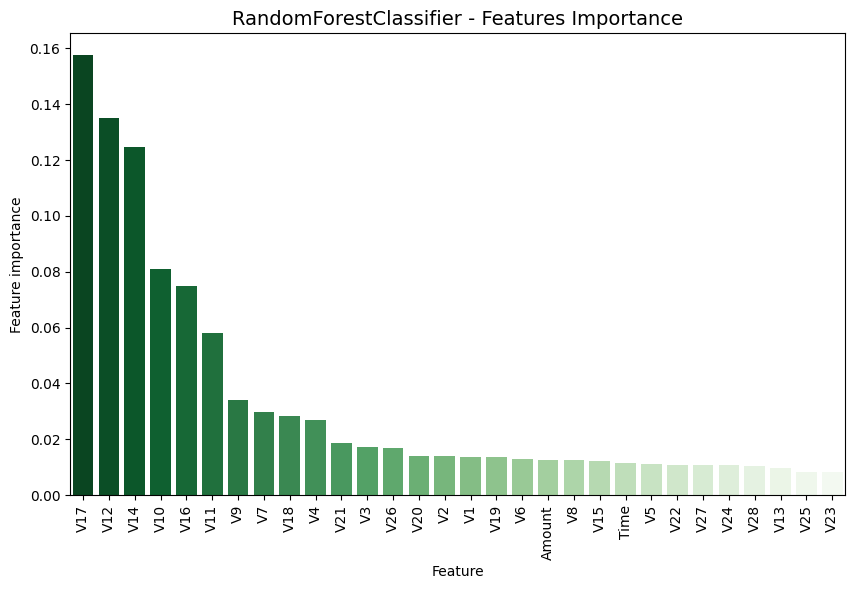

In [46]:
# RandomForestClassifier

temp = pd.DataFrame({'Feature': features, 'Feature importance': rfc.feature_importances_})
temp = temp.sort_values(by='Feature importance',ascending=False)

plt.figure(figsize = (10,6))
plot = sns.barplot(x='Feature',y='Feature importance',data=temp, hue='Feature', palette='Greens_r', legend=False)
plot.set_xticks(range(len(temp)))
plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
plt.title('RandomForestClassifier - Features Importance',fontsize=14)
plt.savefig('../results/visualizations/features_imp_rfc.png', dpi=166.67)
plt.show()

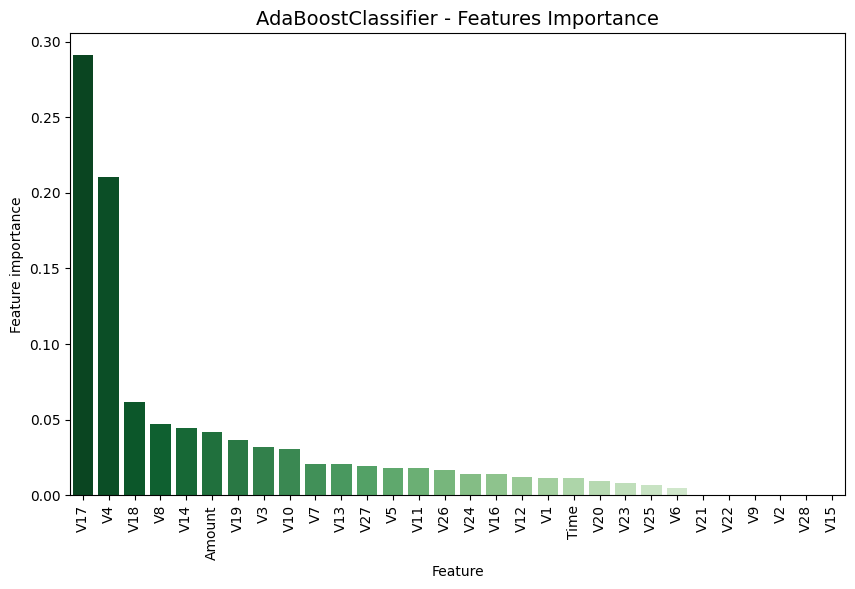

In [47]:
# AdaBoostClassifier

temp = pd.DataFrame({'Feature': features, 'Feature importance': abc.feature_importances_})
temp = temp.sort_values(by='Feature importance',ascending=False)

plt.figure(figsize = (10,6))
plot = sns.barplot(x='Feature',y='Feature importance',data=temp, hue='Feature', palette='Greens_r', legend=False)
plot.set_xticks(range(len(temp)))
plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
plt.title('AdaBoostClassifier - Features Importance',fontsize=14)
plt.savefig('../results/visualizations/features_imp_abc.png', dpi=166.67)
plt.show()

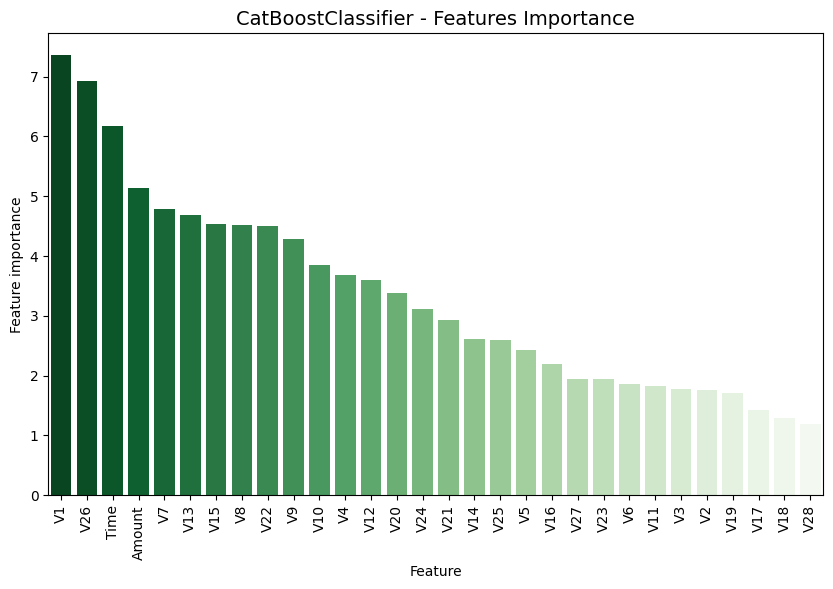

In [48]:
# CatBoostClassifier

temp = pd.DataFrame({'Feature': features, 'Feature importance': cbc.feature_importances_})
temp = temp.sort_values(by='Feature importance',ascending=False)

plt.figure(figsize = (10,6))
plot = sns.barplot(x='Feature',y='Feature importance',data=temp, hue='Feature', palette='Greens_r', legend=False)
plot.set_xticks(range(len(temp)))
plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
plt.title('CatBoostClassifier - Features Importance',fontsize=14)
plt.savefig('../results/visualizations/features_imp_cbc.png', dpi=166.67)
plt.show()

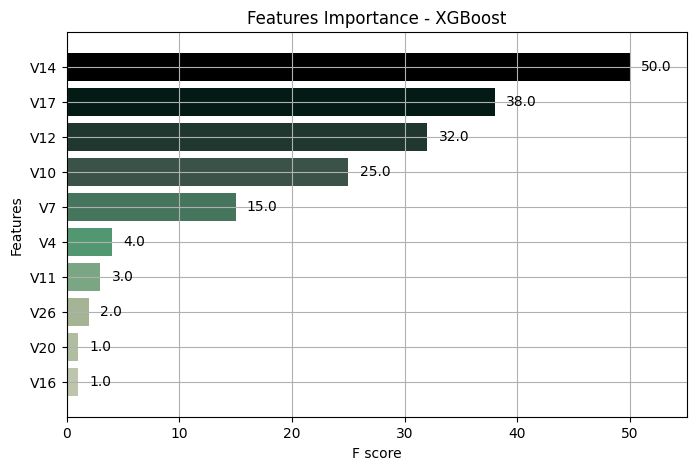

In [54]:
# XGBoost

fig, ax = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(xgb_model, height=0.8, title="Features Importance - XGBoost", ax=ax, color=['#bec5ad', '#b1bda1', '#a4b494', '#7ba683', '#519872', '#46755e', '#3b5249', '#20372f', '#041b15', '#000000']) 
plt.savefig('../results/visualizations/features_imp_xgb.png', dpi=200)
plt.show()